In [ ]:
import os
import sys
import pickle
import torch
import numpy as np
import pandas as pd
import scipy.stats as ss
from classy import Class
from typing import Tuple, List, Dict, Union
import matplotlib.pylab as plt
from ml_collections.config_dict import ConfigDict
from torchemu.gaussianprocess import GaussianProcess
from jax_cosmo.utils import load_pkl, save_pkl

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 20

# Functions

In [9]:
def get_config(experiment) -> ConfigDict:
    """Generates and returns a configuration dictionary for the emulator.

    This function sets up various configuration parameters for the emulator,
    including neutrino settings, CLASS settings, priors, and emulator settings.

    Returns:
        ConfigDict: A configuration dictionary containing the following keys:
            - neutrino: Neutrino settings.
            - classy: CLASS settings.
            - priors: Prior distributions for various parameters.
            - emu: Emulator settings.
    """
    config = ConfigDict()
    config.logname = "des-analysis"
    config.experiment = experiment

    # cosmological parameters
    config.cosmo = cosmo = ConfigDict()
    cosmo.names = ["sigma8", "Omega_cdm", "Omega_b", "h", "n_s"]

    # neutrino settings
    config.neutrino = neutrino = ConfigDict()
    neutrino.N_ncdm = 1.0
    neutrino.deg_ncdm = 3.0
    neutrino.T_ncdm = 0.71611
    neutrino.N_ur = 0.00641
    neutrino.fixed_nm = 0.06

    # CLASS settings
    config.classy = classy = ConfigDict()
    classy.output = "mPk"
    classy.Omega_k = 0.0
    classy.k_max_pk = 50
    classy.k_min_pk = 1e-4
    classy.z_max_pk = 3.0
    classy.nk = 30
    classy.nz = 20

    # priors
    config.priors = {
        "sigma8": {
            "distribution": "uniform",
            "loc": 0.6,
            "scale": 0.4,
            "fiducial": 0.8,
        },
        "Omega_cdm": {
            "distribution": "uniform",
            "loc": 0.07,
            "scale": 0.43,
            "fiducial": 0.2,
        },
        "Omega_b": {
            "distribution": "uniform",
            "loc": 0.028,
            "scale": 0.027,
            "fiducial": 0.04,
        },
        "h": {"distribution": "uniform", "loc": 0.64, "scale": 0.18, "fiducial": 0.7},
        "n_s": {"distribution": "uniform", "loc": 0.87, "scale": 0.2, "fiducial": 1.0},
    }

    # emulator settings
    config.emu = emu = ConfigDict()
    emu.nlhs = 1000
    emu.jitter = 1e-10
    emu.lr = 0.01
    emu.nrestart = 5
    emu.niter = 1000

    return config


def class_args(config: ConfigDict) -> Dict:
    """Generates CLASS arguments to be passed to classy to compute the different quantities.
    Args:
        config (ConfigDict): A configuration file containing the parameters.
    Returns:
        dict: A dictionary to input to class
    """
    dictionary = dict()
    dictionary["output"] = config.classy.output
    dictionary["P_k_max_1/Mpc"] = config.classy.k_max_pk
    dictionary["z_max_pk"] = config.classy.z_max_pk
    dictionary["Omega_k"] = config.classy.Omega_k
    return dictionary


def neutrino_args(config: ConfigDict) -> Dict:
    """Generates a dictionary for the neutrino settings.
    Args:
        config (ConfigDict): The main configuration file
    Returns:
        dict: A dictionary with the neutrino parameters.
    """
    dictionary = dict()
    dictionary["N_ncdm"] = config.neutrino.N_ncdm
    dictionary["deg_ncdm"] = config.neutrino.deg_ncdm
    dictionary["T_ncdm"] = config.neutrino.T_ncdm
    dictionary["N_ur"] = config.neutrino.N_ur
    dictionary["m_ncdm"] = config.neutrino.fixed_nm / config.neutrino.deg_ncdm
    return dictionary


def delete_module(class_module: Class):
    """Deletes the module to prevent memory overflow.
    Args:
        module (Class): A CLASS module
    """
    class_module.struct_cleanup()

    class_module.empty()

    del class_module


def class_compute(config: ConfigDict, cosmology: Dict) -> Class:
    """Pre-computes the quantities in CLASS.
    Args:
        config (ConfigDict): The main configuration file for running Class
        cosmology (dict): A dictionary with the cosmological parameters
    Returns:
        Class: A CLASS module
    """
    # generates the dictionaries to input to Class
    arg_class = class_args(config)
    arg_neutrino = neutrino_args(config)

    # Run Class
    class_module = Class()
    class_module.set(arg_class)
    class_module.set(arg_neutrino)
    class_module.set(cosmology)
    class_module.compute()

    return class_module


def calculate_linear_pk_class(cosmology: Dict, cfg: ConfigDict) -> np.ndarray:
    """Calculate the linear matter power spectrum using CLASS.

    Args:
        cosmology (Dict): A dictionary containing cosmological parameters.
        cfg (ConfigDict): A configuration dictionary containing CLASS settings.

    Returns:
        np.ndarray: An array of linear matter power spectrum values.

    """
    cmodule = class_compute(cfg, cosmology)

    # calculate the linear matter power spectrum
    kvalues = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    class_pklin = []
    for kvalue in kvalues:
        class_pklin.append(
            cosmology["h"] ** 3 * cmodule.pk_lin(cosmology["h"] * kvalue, 0.0)
        )
    class_pklin = np.array(class_pklin)
    delete_module(cmodule)
    return class_pklin


def calculate_quantities(
    cosmology: Dict, cfg: ConfigDict
) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate the linear matter power spectrum at redshift 0 and the growth factor as a function of redshift.

    Args:
        cosmology (Dict): A dictionary containing cosmological parameters.
        cfg (ConfigDict): A configuration dictionary containing CLASS settings.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - np.ndarray: Linear matter power spectrum at redshift 0.
            - np.ndarray: Growth factor as a function of redshift.

    """
    kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    zgrid = np.linspace(0.0, cfg.classy.z_max_pk, cfg.classy.nz)
    cmodule = class_compute(cfg, cosmology)
    class_pklin_z0 = []
    multiplying_factor = []

    # note that JAX cosmo computes everything with a factor h inside
    # which is why we are including the factor h here
    for kvalue in kgrid:
        class_pklin_z0.append(
            cosmology["h"] ** 3 * cmodule.pk_lin(cosmology["h"] * kvalue, 0)
        )
    class_pklin_z0 = np.array(class_pklin_z0)

    for redshift in zgrid:
        factor = cosmology["h"] ** 3 * cmodule.pk_lin(
            cosmology["h"] * kgrid[0], redshift
        )
        multiplying_factor.append(factor / class_pklin_z0[0])
    multiplying_factor = np.array(multiplying_factor)
    delete_module(cmodule)
    return class_pklin_z0, multiplying_factor


def calculate_pklin_redshift(
    cosmology: Dict, cfg: ConfigDict, redshift: float
) -> np.ndarray:
    """Calculate the linear matter power spectrum at any given redshift.

    Args:
        cosmology (Dict): A dictionary containing cosmological parameters.
        cfg (ConfigDict): A configuration dictionary containing CLASS settings.
        redshift (float): The redshift at which to calculate the power spectrum.

    Returns:
        np.ndarray: An array of linear matter power spectrum values at the given redshift.

    """
    kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    cmodule = class_compute(cfg, cosmology)
    class_pklin = []
    for kvalue in kgrid:
        class_pklin.append(
            cosmology["h"] ** 3 * cmodule.pk_lin(cosmology["h"] * kvalue, redshift)
        )
    class_pklin = np.array(class_pklin)
    delete_module(cmodule)
    return class_pklin


def generate_cosmo_priors(cfg: ConfigDict) -> Dict:
    """Generate cosmological priors based on the configuration settings.

    Args:
        cfg (ConfigDict): A configuration dictionary containing cosmological parameter names and their prior distributions.

    Returns:
        Dict: A dictionary where keys are cosmological parameter names and values are their corresponding prior distributions.
    """
    dictionary = dict()
    for name in cfg.cosmo.names:
        param = cfg.priors[name]
        specs = (param.loc, param.scale)
        dictionary[name] = getattr(ss, param.distribution)(*specs)
    return dictionary


def generate_inputs(
    lhs: pd.DataFrame, priors: Dict, save: bool = False, fname: str = "cosmo"
) -> pd.DataFrame:
    """Generate the input training points (the cosmologies).

    This function scales the Latin hypercube samples according to the prior range of the cosmological parameters.

    Args:
        lhs (pd.DataFrame): A DataFrame containing Latin hypercube samples.
        priors (Dict): A dictionary where keys are cosmological parameter names and values are their corresponding prior distributions.
        save (bool, optional): If True, the generated cosmologies will be saved to a CSV file. Defaults to False.
        fname (str, optional): The base filename for saving the generated cosmologies. Defaults to 'cosmo'.

    Returns:
        pd.DataFrame: A DataFrame containing the scaled cosmological parameters.

    """
    cosmologies = {}
    for i, p in enumerate(priors):
        cosmologies[p] = priors[p].ppf(lhs.iloc[:, i].values)
    cosmologies = pd.DataFrame(cosmologies)
    if save:
        os.makedirs("data", exist_ok=True)
        cosmologies.to_csv(f"data/{fname}.csv")
    return cosmologies


def generate_outputs(
    cosmologies: pd.DataFrame, cfg: ConfigDict, save: bool = False
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Generate the output training points (the power spectra and growth factors).

    This function calculates the linear matter power spectrum and growth factor for each set of cosmological parameters.

    Args:
        cosmologies (pd.DataFrame): A DataFrame containing the cosmological parameters.
        cfg (ConfigDict): A configuration dictionary containing CLASS settings.
        save (bool, optional): If True, the generated power spectra and growth factors will be saved to CSV files. Defaults to False.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - pd.DataFrame: A DataFrame of linear matter power spectra for each cosmology.
            - pd.DataFrame: A DataFrame of growth factors for each cosmology.

    """
    ncosmo = cosmologies.shape[0]
    record_pklin = []
    record_gf = []
    for i in range(ncosmo):
        cosmology = dict(cosmologies.iloc[i])
        train_pklin, train_gf = calculate_quantities(cosmology, cfg)
        record_pklin.append(train_pklin)
        record_gf.append(train_gf)
    record_pklin = pd.DataFrame(record_pklin)
    record_gf = pd.DataFrame(record_gf)
    if save:
        os.makedirs("data", exist_ok=True)
        record_pklin.to_csv("data/pklin.csv")
        record_gf.to_csv("data/gf.csv")
    return record_pklin, record_gf


def train_gps(
    config: ConfigDict,
    cosmologies: torch.Tensor,
    outputs: torch.Tensor,
    prewhiten: bool,
    ylog: bool,
    fname="pklin",
) -> List:
    """Train Gaussian Processes (GPs) for the given cosmologies and outputs.

    This function optimizes the kernel parameters for each output dimension and saves the trained GP models.

    Args:
        config (ConfigDict): A configuration dictionary containing emulator settings.
        cosmologies (torch.Tensor): A tensor containing the cosmological parameters.
        outputs (torch.Tensor): A tensor containing the output values for each cosmology.
        prewhiten (bool): If True, prewhiten the data before training.
        ylog (bool): If True, apply a logarithmic transformation to the output values.
        fname (str, optional): The base filename for saving the trained GP models. Defaults to 'pklin'.

    Returns:
        List[GaussianProcess]: A list of trained GaussianProcess models.

    """
    nout = outputs.shape[1]
    record = []
    for i in range(nout):

        # optimise for the kernel parameters
        gpmodule = GaussianProcess(
            config, cosmologies, outputs[:, i], prewhiten=prewhiten, ylog=ylog
        )
        parameters = torch.randn(6)
        opt_params = gpmodule.optimisation(
            parameters,
            niter=config.emu.niter,
            lrate=config.emu.lr,
            nrestart=config.emu.nrestart,
        )

        # save the gps and quantities
        save_pkl(gpmodule, "gps", fname + f"_{i}")
        record.append(gpmodule)
    return record


def save_quantities(gps: GaussianProcess, fname: str):
    """Save the quantities of trained Gaussian Process models for use with JAX.

    This function records various quantities from each trained GP model and saves them to a file.

    Args:
        gps (GaussianProcess): A list of trained GaussianProcess models.
        fname (str): The base filename for saving the quantities.

    """
    for i, gpmodule in enumerate(gps):
        # record all quantities to be used for JAX
        quantities = {}
        quantities["hyperparams"] = gpmodule.opt_parameters.data.numpy()
        quantities["cholfactor"] = gpmodule.chol_train.data.numpy()
        quantities["meanparams"] = gpmodule.mean_train.data.numpy()
        quantities["alpha"] = gpmodule.alpha.data.numpy()
        quantities["ystd"] = gpmodule.ystd.data.numpy()
        quantities["ymean"] = gpmodule.ymean.data.numpy()
        quantities["xtrain"] = gpmodule.xtrain.data.numpy()
        save_pkl(quantities, "jax_cosmo/quantities", fname + f"_{i}")


def interpolate_1d(
    fine_x: Union[np.ndarray, list],
    coarse_x: Union[np.ndarray, list],
    coarse_y: Union[np.ndarray, list],
    xlog: bool = False,
    ylog: bool = False,
) -> np.ndarray:
    """Interpolate 1D data from coarse to fine grid.

    Args:
        fine_x (Union[np.ndarray, list]): The fine grid x-values where interpolation is desired.
        coarse_x (Union[np.ndarray, list]): The coarse grid x-values.
        coarse_y (Union[np.ndarray, list]): The coarse grid y-values.
        xlog (bool, optional): If True, apply logarithmic transformation to x-values before interpolation. Defaults to False.
        ylog (bool, optional): If True, apply logarithmic transformation to y-values before interpolation. Defaults to False.

    Returns:
        np.ndarray: The interpolated y-values on the fine grid.

    """
    if xlog:
        fine_x = np.log(fine_x)
        coarse_x = np.log(coarse_x)
    if ylog:
        coarse_y = np.log(coarse_y)
    ypred = np.interp(fine_x, coarse_x, coarse_y)
    if ylog:
        ypred = np.exp(ypred)
    return ypred


def calculate_accuracy(
    gps_pklin: list,
    gps_gf: list,
    testcosmo: pd.DataFrame,
    cfg: ConfigDict,
    use_interp: bool,
) -> dict:
    """Calculate the accuracy of Gaussian Process predictions against CLASS calculations.

    This function compares the linear matter power spectrum and growth factor predictions from Gaussian Processes (GPs)
    with those from CLASS for a set of test cosmologies. It optionally interpolates the results to a finer grid.

    Args:
        gps_pklin (list): A list of trained GaussianProcess models for the linear matter power spectrum.
        gps_gf (list): A list of trained GaussianProcess models for the growth factor.
        testcosmo (pd.DataFrame): A DataFrame containing the test cosmological parameters.
        cfg (ConfigDict): A configuration dictionary containing CLASS settings.
        use_interp (bool): If True, interpolate the results to a finer grid.

    Returns:
        dict: A dictionary containing the CLASS and GP predictions, as well as the relative differences.

    """
    # coarse and fine grid for wavenumber
    kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    kfine = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, 1000)

    # coarse and fine grid for redshift
    zgrid = np.linspace(0.0, cfg.classy.z_max_pk, cfg.classy.nz)
    zfine = np.linspace(0.0, cfg.classy.z_max_pk, 1000)

    ntest = testcosmo.shape[0]
    record = {
        "class_pklin": [],
        "class_gf": [],
        "gp_pklin": [],
        "gp_gf": [],
        "delta_pklin": [],
        "delta_gf": [],
    }
    for i in range(ntest):
        cosmo_dict = dict(testcosmo.iloc[i])
        cosmo_tensor = torch.tensor(testcosmo.iloc[i].values).view(-1)

        pklin_class, gf_class = calculate_quantities(cosmo_dict, cfg)
        pklin_gp = [
            gps_pklin[j].prediction(cosmo_tensor).item() for j in range(cfg.classy.nk)
        ]
        gf_gp = [1] + [
            gps_gf[j].prediction(cosmo_tensor).item() for j in range(cfg.classy.nz - 1)
        ]

        if use_interp:
            pklin_class = interpolate_1d(
                kfine, kgrid, pklin_class, xlog=True, ylog=True
            )
            pklin_gp = interpolate_1d(kfine, kgrid, pklin_gp, xlog=True, ylog=True)
            gf_gp = interpolate_1d(zfine, zgrid, gf_gp, xlog=False, ylog=False)
            gf_class = interpolate_1d(zfine, zgrid, gf_class, xlog=False, ylog=False)

        record["class_pklin"].append(pklin_class)
        record["class_gf"].append(gf_class)
        record["gp_pklin"].append(np.array(pklin_gp))
        record["gp_gf"].append(np.array(gf_gp))
        record["delta_pklin"].append((pklin_class - pklin_gp) / pklin_class)
        record["delta_gf"].append((gf_class - gf_gp) / gf_class)
        record["testcosmo"] = testcosmo

    save_pkl(record, "data", "accuracy")

    return record

In [13]:
cfg = get_config("test")
cosmo = {
    "sigma8": 0.857570,
    "Omega_cdm": 0.217284,
    "Omega_b": 0.038872,
    "h": 0.711447,
    "n_s": 1.001982,
}
kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
zgrid = np.linspace(0.0, cfg.classy.z_max_pk, cfg.classy.nz)
class_pklin = calculate_linear_pk_class(cosmo, cfg)

# Training Set

In [23]:
lhs = pd.read_csv("data/lhs_1000.csv", index_col=0)
cosmo_priors = generate_cosmo_priors(cfg)
# cosmologies = generate_inputs(lhs, cosmo_priors, save = False)

In [370]:
cosmologies = pd.read_csv("data/cosmologies.csv", index_col=0)

In [ ]:
%%time
# record_pklin, record_gf = generate_outputs(cosmologies, cfg, save=True) # this should be done once
# this took about 1 hour

In [367]:
record_pklin = pd.read_csv("data/pklin.csv", index_col=0)
record_gf = pd.read_csv("data/gf.csv", index_col=0)

# Emulator

In [74]:
inputs = torch.from_numpy(cosmologies.values)
outputs_pklin = torch.from_numpy(record_pklin.values)
outputs_gf = torch.from_numpy(record_gf.values[:, 1:])

In [77]:
%%time
# gps_pklin = train_gps(cfg, inputs, outputs_pklin, True, True, 'pklin') # this is done once
# CPU times: user 10h 24min 47s, sys: 7min 8s, total: 10h 31min 56s
# Wall time: 1h 19min 28s

CPU times: user 10h 24min 47s, sys: 7min 8s, total: 10h 31min 56s
Wall time: 1h 19min 28s


In [78]:
%%time
# gps_gf = train_gps(cfg, inputs, outputs_gf, True, False, 'gf') # this is done once
# CPU times: user 6h 38min 19s, sys: 1min 34s, total: 6h 39min 54s
# Wall time: 50min 18s

Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
CPU times: user 6h 38min 19s, sys: 1min 34s, total: 6h 39min 54s
Wall time: 50min 18s


In [305]:
# save_quantities(gps_pklin, 'pklin')
# save_quantities(gps_gf, 'gf')

# Testing

We just need to load the trained GPs before making predictions

In [18]:
loaded_gps_pklin = [load_pkl("gps/", f"pklin_{i}") for i in range(cfg.classy.nk)]
loaded_gps_gf = [load_pkl("gps/", f"gf_{i}") for i in range(cfg.classy.nz - 1)]

In [30]:
ndim = 5
ntest = 1000
test_samples = pd.DataFrame(
    np.random.uniform(0, 1, (ntest, ndim)), columns=[f"V{i+1}" for i in range(ndim)]
)
cosmo_priors = generate_cosmo_priors(cfg)
test_cosmo = generate_inputs(test_samples, cosmo_priors, save=False)

In [31]:
test_cosmo.head()

,sigma8,Omega_cdm,Omega_b,h,n_s
0,0.705508,0.178396,0.041769,0.756473,1.053305
1,0.946655,0.080980,0.041294,0.806770,0.885890
2,0.925953,0.336557,0.028025,0.799644,1.007255
3,0.858123,0.166238,0.047028,0.813817,1.060033
4,0.821082,0.316000,0.034845,0.719551,0.935759


In [213]:
%%time
# record = calculate_accuracy(loaded_gps_pklin, loaded_gps_gf, test_cosmo, cfg, use_interp=True)

CPU times: user 1h 7min 21s, sys: 1.86 s, total: 1h 7min 23s
Wall time: 11min 23s


In [13]:
record = load_pkl("data", "accuracy")

In [15]:
delta_pklin = np.vstack(record["delta_pklin"])
delta_gf = np.vstack(record["delta_gf"])

mean_delta_pklin = np.mean(delta_pklin, axis=0) * 100
std_delta_pklin = np.std(delta_pklin, axis=0) * 100

mean_delta_gf = np.mean(delta_gf, axis=0) * 100
std_delta_gf = np.std(delta_gf, axis=0) * 100

In [18]:
kfine = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, 1000)
zfine = np.linspace(0.0, cfg.classy.z_max_pk, 1000)

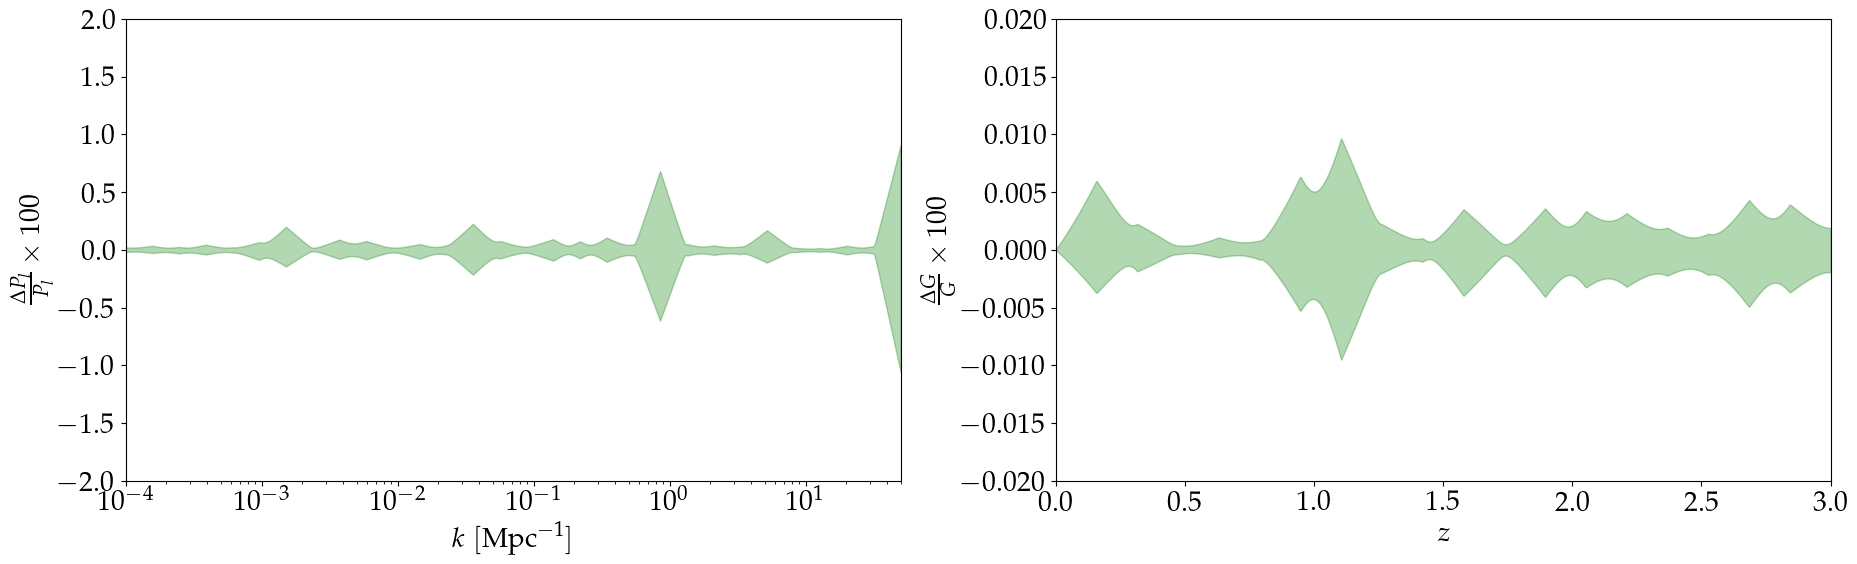

In [24]:
plt.figure(figsize=(22, 6))
plt.subplot(121)
plt.fill_between(
    kfine,
    mean_delta_pklin + 3 * std_delta_pklin,
    mean_delta_pklin - 3 * std_delta_pklin,
    alpha=0.3,
    color="g",
)
plt.ylim(-2, 2)
plt.xlim(min(kfine), max(kfine))
plt.ylabel(r"$\frac{\Delta P_{l}}{P_{l}}\times 100$", fontsize=fontSize)
plt.xlabel(r"$k\;[\textrm{Mpc}^{-1}]$", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
plt.xscale("log")

plt.subplot(122)
plt.fill_between(
    zfine,
    mean_delta_gf + 3 * std_delta_gf,
    mean_delta_gf - 3 * std_delta_gf,
    alpha=0.3,
    color="g",
)
plt.ylim(-0.02, 0.02)
plt.xlim(min(zfine), max(zfine))
plt.ylabel(r"$\frac{\Delta G}{G}\times 100$", fontsize=fontSize)
plt.xlabel(r"$z$", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
# plt.savefig('plots/emu_accuracy.pdf', bbox_inches = 'tight')
plt.show()